In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create VI Dataset v7

**Changes**

* Cloud correction

--> Basically, ignore all pixels that are possibly a cloud by replacing them with NaNs

In [16]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import rasterio

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import  read_shapefile 
from src.utils import mask_raster

dataset_version = "v7.1"

## VI Methods

In [17]:
from src.data.vi_methods import *

In [18]:
import time
from multiprocessing import Pool
from functools import partial

def load_for_id(farm_id, dataset, bands_subset=None):
    """
    Load all data for a farm
    
    Return:
    
    dictionary: {band: {date: ndarray}, {...}}
    """
    farm_dir = interim_data_dir / 'masks_resampled' / dataset / str(farm_id)

    dates = farm_dir.glob('*/')
    farm_data = {}
    
    for date_path in dates:
        
        date = date_path.stem

        bands = date_path.glob("*.npy")
        
        farm_data[date_path.stem] = {}
        
        for band_path in bands:
            band = band_path.stem
            
            if bands_subset and band not in bands_subset:
                continue
            else:
                arr = np.load(band_path)
                farm_data[date][band] = arr
        
    return farm_data

In [19]:
dates_with_clouds = ['2017-02-10','2017-08-04','2017-08-19']


def cloud_correction(farm_data, farm_id, cloud_masks):
    for date, cloud_mask_dict in cloud_masks.items():
        if date not in list(farm_data.keys()):
            raise ValueError("Farm {} does not have date: {}. Valid dates: {}".format(farm_id, date, list(farm_data.keys())))
        for band in farm_data[date].keys():
            # replace with nan where mask is 1
            farm_data[date][band] = np.where(cloud_mask_dict[farm_id] == 1, np.nan, farm_data[date][band])
            
def get_cloud_masks(shapes):
    """
    Get cloud masks for all farms 
    for all dates
    """
    cloud_masks = {}
    
    for date in dates_with_clouds:
    
        f_mask = interim_data_dir / 'cloud_masks' / date / 'mask_10m.jp2'

        with rasterio.open(f_mask) as cloud_raster:
            cloud_masks[date] = mask_raster(shapes, cloud_raster)
    
    return cloud_masks
            
            
def f(farm_id, dataset, bands_subset, agg_methods, cloud_masks):
    farm_data = load_for_id(farm_id, dataset, bands_subset=bands_subset)
    
    # cloud correction (in place)
    cloud_correction(farm_data, farm_id, cloud_masks)

    vi_data = [calc_vi_ts(farm_data, farm_id, agg_methods, vi_method) for vi_method in vi_methods]

    vi_df = pd.concat(vi_data, axis=1)
    
    # interpolate missing values
    vi_df = vi_df.sort_index(level=1).interpolate(axis=0, method='linear')

    return vi_df



def create_features_dataset_multi(dataset='train', bands_subset=None, agg_methods=['mean','median'], limit_farms=None, add_bands=True):
    """
    A multi-processing solution
    
    """
    
    shp_df = read_shapefile(dataset)
    
    ids_list = shp_df.index.to_list()
    
    if limit_farms:
        ids_list = ids_list[:limit_farms]
    
    # Get cloud masks
    cloud_masks = get_cloud_masks(shp_df.loc[ids_list].geometry)
        
    partials = partial(f, dataset=dataset, bands_subset=bands_subset, agg_methods=agg_methods, cloud_masks=cloud_masks)
        
    pool = Pool(processes=10)
    result = pool.map_async(partials, ids_list)
    
    i = 0
    t_start = time.time()
    while not result.ready():
        if i == 10:
            i=0
            e = int(time.time() - t_start)
            print('\n Elapsed: {:02d}:{:02d}:{:02d}'.format(e // 3600, (e % 3600 // 60), e % 60))
        print('.',end='')
        i += 1
        time.sleep(0.5)
    
    vi_dfs = result.get()
    
    df = pd.concat(vi_dfs, axis=0).reset_index()
    
    if dataset=='train':
        df = df.join(shp_df[['y']], on='farm_id')
        
    df.time = pd.to_datetime(df.time)
    
    # Sort each farm by time
    df = df.sort_values(by=['farm_id','time'])
    
    # After sorting the index will be jumbled, lets throw that away
    df.reset_index(drop=True, inplace=True)
    
    df['farm_id'] = df['farm_id'].astype(str)
    
    return df

In [20]:
%%time

vi_methods = [
    'ndvi',
    'cvi',
    'evi',
    'arvi2',
    'arvi',
    'datt1',
    'atsavi',
    'maccioni',
    'gari',
    'gbndvi',
    'mnsi',
    'msbi',
    'band_2',
    'band_3',
    'band_4',
    'band_5',
    'band_6',
    'band_7',
    'band_8',
    'band_8a',
    'band_11',
    'band_12',
]


print('-'*50,'Train','-'*50)

train_features_df = create_features_dataset_multi(
    dataset='train',
    agg_methods=['mean','median','min','max','std'],
)

-------------------------------------------------- Train --------------------------------------------------
..........
 Elapsed: 00:00:05
..........
 Elapsed: 00:00:10
..........
 Elapsed: 00:00:15
..........
 Elapsed: 00:00:20
..........
 Elapsed: 00:00:25
..........
 Elapsed: 00:00:30
..........
 Elapsed: 00:00:35
..........
 Elapsed: 00:00:40
..........
 Elapsed: 00:00:45
..........
 Elapsed: 00:00:50
..........
 Elapsed: 00:00:55
..........
 Elapsed: 00:01:00
..........
 Elapsed: 00:01:05
..........
 Elapsed: 00:01:11
..........
 Elapsed: 00:01:16
..........
 Elapsed: 00:01:21
..........
 Elapsed: 00:01:26
..........CPU times: user 17.2 s, sys: 2.57 s, total: 19.8 s
Wall time: 1min 43s


In [21]:
print('\n')
print('-'*50,'Test','-'*50)
test_features_df = create_features_dataset_multi(
    dataset='test', 
    agg_methods=['mean','median','min','max','std'],
)



-------------------------------------------------- Test --------------------------------------------------
..........
 Elapsed: 00:00:05
..........
 Elapsed: 00:00:10
..........
 Elapsed: 00:00:15
..........
 Elapsed: 00:00:20
..........
 Elapsed: 00:00:25
..........
 Elapsed: 00:00:30
..........
 Elapsed: 00:00:35
....

In [22]:
train_features_df.shape, test_features_df.shape

((27434, 113), (11814, 112))

## Spot check a few known to have clouds

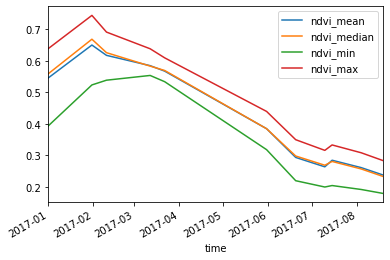

In [23]:
train_features_df.loc[train_features_df.farm_id == '15'][['time',
                                                          'ndvi_mean',
                                                          'ndvi_median',
                                                          'ndvi_min',
                                                          'ndvi_max']].set_index('time').plot()

In [24]:
train_features_df.shape

(27434, 113)

## Save to disk

In [25]:
from config import processed_data_dir
from src.utils import safe_create_dir

out_dir = processed_data_dir / 'VI_datasets' / dataset_version
safe_create_dir(out_dir)

train_features_df.farm_id = train_features_df.farm_id.astype(str)
test_features_df.farm_id = test_features_df.farm_id.astype(str)

train_features_df.to_csv(out_dir/'train.csv')
test_features_df.to_csv(out_dir/'test.csv')

In [26]:
train_features_df.farm_id.dtype

dtype('O')